# Understanding LMS-based Color Blindness Simulations
> Diving deeper in the theory of Viénot, Brettel & Mollon's method to understand what's behind the scene.

- toc: true 
- badges: true
- comments: true
- categories: [simulation]
- permalink: /understanding-cvd-simulation/
- image: images/chart-preview.png
- hide: false

In [1]:
# hide
%load_ext autoreload
%autoreload 2

In [2]:
# hide
%pip install -q pandas Geometry3D colour-science
%pip install -q --upgrade plotly daltonlens

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# hide_input
import plotly.io as pio
if pio.renderers.default != 'colab':
    pio.renderers.default = 'notebook_connected'
from IPython.display import display, HTML
js = '<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.6/require.min.js" integrity="sha512-c3Nl8+7g4LMSTdrm621y7kf9v3SDPnhxLNhcjFJbKECVnmZHTdo+IRO05sNLTH/D3vA6u1X32ehoLC7WFVdheg==" crossorigin="anonymous"></script>'
display(HTML(js))

# Introduction

This post is a followup to our [Review of Open Source Color Blindness Simulations](/opensource-cvd-simulation/) and assumes that you are familiar with color vision deficiencies (CVD) simulation. The goal of this post is to dive into _how_ these methods actually work. To visualize and play with the models interactively this page is actually generated from a Jupyter notebook (using [fastpages](https://github.com/fastai/fastpages)) and can be run in e.g. [Google colab](https://colab.research.google.com/github/DaltonLens/daltonlens.org/blob/master/_notebooks/2021-10-30-Understanding-Color-Blindness-Simulations.ipynb) to play with it.

{% cite brettel_computerized_1997 %}, {% cite vienot_digital_1999 %} and {% cite machado_physiologically_based_2009 %} all rely on the same low-level principles to simulate CVD. For all of them the final code will basically just apply a sRGB/gamma function, one or two 3x3 matrices, undo the gamma, and call it a day. But we're going to analyze that pipeline and try to understand how to compute those matrices and get a sense of what they do.

The Machado 2009 method is actually a bit more involved as it uses a second stage of modeling (opponent-color theory), so we will not cover it here and only focus on Viénot 1999 and Brettel 1997. Both focus on full dichromacy, so we'll start with that. The extension to anomalous trichromacy will be discussed in section [What about anomalous trichromacy?](#What-about-anomalous-trichromacy?), and it's worth noting that Machado 2009 has similar results for dichromacy anyway. 

Let's first get an overview of the process. Protanopes, deuteranopes and tritanopes respectively lack the L, M, and S cone cells. Thus a natural approach to simulate dichromacy is to go to the LMS color-space and somehow remove the component coming from the missing cone cells. The good news is that going from an RGB color space to LMS can be done with a linear transformation (matrix multiplication). But as usual there are many ways to do it and it'll deserve its own section.

One extra complexity is that images are typically encoded in `sRGB` to get properly displayed on digital monitors. So our first step will be to go from sRGB to linear RGB, and then from there to LMS.

Once in the LMS color space, colors that only differ by the coordinate of the axis corresponding to the missing cone cannot be differentiated by a dichromat. This creates so-called confusion lines, which are, by construction, parallel to the missing axis in the LMS color space. So according to this model a protanope cannot distinguish colors that only differ by their L component, a deuteranope those that only differ by their M component, and tritanopes those that only differ by their S component.

To illustrate this let's build a plot with a few confusion lines in the LMS space, and their counterpart on the linear RGB space. The code to generate the confusion lines is in the [Appendix](#Code-to-generate-the-confusion-lines-of-the-introduction). We'll going to just draw 5 precomputed lines, starting with protanopia (missing L cones). To have a reference we'll also add the gamut (range) of colors that can be produced by a digital monitor. It's a cube in the RGB color space, and a parallelepiped in the LMS space. The 8 vertices are black (`K = RGB[0,0,0]`), white (`W = RGB[1, 1, 1])`, red (`R = RGB[1, 0, 0])`, green (`G = RGB[0,1,0]`), blue (`B = RGB[0,0,1]`), yellow (`G = RGB[1,1,0]`), magenta (`M = RGB[1,0,1]`) and cyan (`C = RGB[0,1,1]`). 

> Note: the plots are in 3D and interactive, so feel free to play with the point of view!

In [4]:
# collapse-hide
# This cell defines all our imports and a few utilities
import itertools
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import pandas as pd
import Geometry3D as geo3d

import daltonlens.convert as convert
import daltonlens.generate as generate
import daltonlens.simulate as simulate
import daltonlens.geometry as geometry
np.set_printoptions(suppress=True)

def printMatrix(name, m):
    mat_str = '\n  '.join(np.array_repr(m).split('\n'))
    print (f'{name} = \n  {mat_str}')
    
# Utility for plotly imshow
hide_image_axes = dict(yaxis_visible=False, yaxis_showticklabels=False, xaxis_visible=False, xaxis_showticklabels=False, margin=dict(l=0, r=0, b=0, t=0))

In [5]:
# collapse-hide

def show_confusion_lines(title, lines):
    rgb_cube = pd.DataFrame.from_records([
        ('K', 'black',     0,   0,   0, 0.        , 0.        , 0.        , '#000000'),
        ('B', 'blue',      0,   0,   1, 0.03596577, 0.03620635, 0.01528089, '#0000ff'),
        ('M', 'magenta',   1,   0,   1, 0.21482533, 0.07001029, 0.01559176, '#ff00ff'),
        ('R', 'red',       1,   0,   0, 0.17885956, 0.03380394, 0.00031087, '#ff0000'),
        ('G', 'green',     0,   1,   0, 0.43997117, 0.27515242, 0.00191661, '#00ff00'),
        ('C', 'cyan',      0,   1,   1, 0.47593694, 0.31135877, 0.0171975 , '#00ffff'),
        ('W', 'white',     1,   1,   1, 0.6547965 , 0.34516271, 0.01750837, '#ffffff'),
        ('Y', 'yellow',    1,   1,   0, 0.61883073, 0.30895636, 0.00222748, '#ffff00')],
        columns = ['short_name', 'name', 'R', 'G', 'B', 'L', 'M', 'S', 'sRGB_hex'])
    rgb_cube.index = rgb_cube['short_name']
    rgb_cube.index.name = 'key'
    # display(HTML("<h2>RGB Cube</h2>"), rgb_cube)
    
    fig = make_subplots(1,2, 
                        subplot_titles=('RGB Color Space',  'LMS Color Space'),
                        specs=[[{"type": "scene"}, {"type": "scene"}]])

    fig.add_scatter3d(x=rgb_cube['R'], y=rgb_cube['G'], z=rgb_cube['B'], 
                      text=rgb_cube.index, mode="markers+text",
                      showlegend=False,
                      marker=dict(color=rgb_cube['sRGB_hex']),
                      row=1, col=1)

    fig.add_scatter3d(x=rgb_cube['L'], y=rgb_cube['M'], z=rgb_cube['S'], 
                      text=rgb_cube.index, mode="markers+text",
                      showlegend=False,
                      marker=dict(color=rgb_cube['sRGB_hex']),
                      row=1, col=2)

    fig.update_layout(title=title)

    fig.update_layout(dragmode='orbit', 
                      scene = dict(
                        xaxis_title='R',
                        yaxis_title='G',
                        zaxis_title='B'))

    fig.update_layout(scene2 = dict(
                        xaxis_title='L',
                        yaxis_title='M',
                        zaxis_title='S'))
    
    # Add the parallelepiped lines
    df = rgb_cube.loc[['K','B','M','R', 'K', 'G', 'Y', 'W', 'C', 'G', 'Y', 'R', 'M', 'W', 'C', 'B']]    
    fig.add_scatter3d(x=df['R'], y=df['G'], z=df['B'], mode='lines', showlegend=False, row=1, col=1)
    fig.add_scatter3d(x=df['L'], y=df['M'], z=df['S'], mode='lines', showlegend=False, row=1, col=2)

    for line in lines:
        fig.add_scatter3d(x=line['R'], y=line['G'], z=line['B'], showlegend=False, 
                          marker=dict(color=line['sRGB_hex']),
                          row=1, col=1)

        fig.add_scatter3d(x=line['L'], y=line['M'], z=line['S'], showlegend=False, 
                          marker=dict(color=line['sRGB_hex']),
                          row=1, col=2)

    fig.show()

# Confusion lines for Deficiency.PROTAN
protan_confusion_lines = [
    pd.DataFrame.from_records([
        (0.2309, 0.0690, 0.0035, 1.0000, 0.1022, 0.1960, '#fe5a7a'),
        (0.2101, 0.0690, 0.0035, 0.8333, 0.1226, 0.1968, '#eb627a'),
        (0.1893, 0.0690, 0.0035, 0.6667, 0.1430, 0.1977, '#d5697a'),
        (0.1684, 0.0690, 0.0035, 0.5000, 0.1633, 0.1985, '#bb707b'),
        (0.1476, 0.0690, 0.0035, 0.3334, 0.1837, 0.1993, '#9c767b'),
        (0.1268, 0.0690, 0.0035, 0.1667, 0.2041, 0.2002, '#717c7b'),
        (0.1060, 0.0690, 0.0035, 0.0001, 0.2244, 0.2010, '#00827b')],
        columns = ['L', 'M', 'S', 'R', 'G', 'B', 'sRGB_hex']),
    pd.DataFrame.from_records([
        (0.3899, 0.1726, 0.0088, 1.0000, 0.4389, 0.4975, '#feb0bb'),
        (0.3690, 0.1726, 0.0088, 0.8333, 0.4593, 0.4983, '#ebb4bb'),
        (0.3482, 0.1726, 0.0088, 0.6667, 0.4796, 0.4992, '#d5b8bb'),
        (0.3274, 0.1726, 0.0088, 0.5000, 0.5000, 0.5000, '#bbbbbb'),
        (0.3066, 0.1726, 0.0088, 0.3334, 0.5204, 0.5008, '#9cbebb'),
        (0.2858, 0.1726, 0.0088, 0.1667, 0.5407, 0.5017, '#71c2bb'),
        (0.2649, 0.1726, 0.0088, 0.0001, 0.5611, 0.5025, '#00c5bb')],
        columns = ['L', 'M', 'S', 'R', 'G', 'B', 'sRGB_hex']),
    pd.DataFrame.from_records([
        (0.2754, 0.1044, 0.0120, 1.0000, 0.1584, 0.7462, '#fe6ee0'),
        (0.2546, 0.1044, 0.0120, 0.8333, 0.1787, 0.7471, '#eb75e0'),
        (0.2337, 0.1044, 0.0120, 0.6667, 0.1991, 0.7479, '#d57be0'),
        (0.2129, 0.1044, 0.0120, 0.5000, 0.2194, 0.7487, '#bb80e0'),
        (0.1921, 0.1044, 0.0120, 0.3334, 0.2398, 0.7496, '#9c86e0'),
        (0.1713, 0.1044, 0.0120, 0.1667, 0.2602, 0.7504, '#718be0'),
        (0.1505, 0.1044, 0.0120, 0.0001, 0.2805, 0.7513, '#0090e0')],
        columns = ['L', 'M', 'S', 'R', 'G', 'B', 'sRGB_hex']),
    pd.DataFrame.from_records([
        (0.5043, 0.2408, 0.0055, 1.0000, 0.7195, 0.2487, '#fedc88'),
        (0.4835, 0.2408, 0.0055, 0.8333, 0.7398, 0.2496, '#ebdf88'),
        (0.4627, 0.2408, 0.0055, 0.6667, 0.7602, 0.2504, '#d5e189'),
        (0.4419, 0.2408, 0.0055, 0.5000, 0.7805, 0.2513, '#bbe489'),
        (0.4211, 0.2408, 0.0055, 0.3334, 0.8009, 0.2521, '#9ce789'),
        (0.4003, 0.2408, 0.0055, 0.1667, 0.8213, 0.2529, '#71e989'),
        (0.3794, 0.2408, 0.0055, 0.0001, 0.8416, 0.2538, '#00ec89')],
        columns = ['L', 'M', 'S', 'R', 'G', 'B', 'sRGB_hex']),
    pd.DataFrame.from_records([
        (0.5488, 0.2761, 0.0140, 1.0000, 0.7756, 0.7990, '#fee3e6'),
        (0.5280, 0.2761, 0.0140, 0.8333, 0.7959, 0.7998, '#ebe6e7'),
        (0.5072, 0.2761, 0.0140, 0.6667, 0.8163, 0.8007, '#d5e9e7'),
        (0.4864, 0.2761, 0.0140, 0.5000, 0.8367, 0.8015, '#bbebe7'),
        (0.4655, 0.2761, 0.0140, 0.3334, 0.8570, 0.8023, '#9ceee7'),
        (0.4447, 0.2761, 0.0140, 0.1667, 0.8774, 0.8032, '#71f0e7'),
        (0.4239, 0.2761, 0.0140, 0.0001, 0.8977, 0.8040, '#00f3e7')],
        columns = ['L', 'M', 'S', 'R', 'G', 'B', 'sRGB_hex']),
]

show_confusion_lines('Examples of protan confusion lines', protan_confusion_lines)

The colors of some of the 5 lines might be easier to discriminate for some protan, but overall with this point size they should be pretty difficult to differentiate on a monitor screen.

See how the confusion lines are parallel to the L axis in the LMS color space, but not aligned with any axis in the RGB space. As expected for protanopes, the colors along the confusion lines vary mostly by their red and green components and are pretty much orthogonal to the blue axis.

Let's also visualize some lines for deuteranopes (parallel to the M axis) and tritanopes (parallel to the S axis).

In [6]:
# collapse-hide

# Confusion lines for Deficiency.DEUTAN
deutan_confusion_lines = [
    pd.DataFrame.from_records([
        (0.1310, 0.0311, 0.0035, 0.6889, 0.0000, 0.2151, '#d8007f'),
        (0.1310, 0.0400, 0.0035, 0.5741, 0.0470, 0.2116, '#c73d7e'),
        (0.1310, 0.0489, 0.0035, 0.4593, 0.0939, 0.2080, '#b4567d'),
        (0.1310, 0.0578, 0.0035, 0.3445, 0.1409, 0.2045, '#9e687c'),
        (0.1310, 0.0667, 0.0035, 0.2297, 0.1879, 0.2009, '#83787b'),
        (0.1310, 0.0756, 0.0035, 0.1149, 0.2348, 0.1974, '#5f857a'),
        (0.1310, 0.0846, 0.0035, 0.0000, 0.2818, 0.1938, '#009079')],
        columns = ['L', 'M', 'S', 'R', 'G', 'B', 'sRGB_hex']),
    pd.DataFrame.from_records([
        (0.3274, 0.1338, 0.0088, 1.0000, 0.2955, 0.5155, '#fe93be'),
        (0.3274, 0.1467, 0.0088, 0.8333, 0.3636, 0.5103, '#eba2bd'),
        (0.3274, 0.1596, 0.0088, 0.6667, 0.4318, 0.5052, '#d5afbc'),
        (0.3274, 0.1726, 0.0088, 0.5000, 0.5000, 0.5000, '#bbbbbb'),
        (0.3274, 0.1855, 0.0088, 0.3334, 0.5682, 0.4948, '#9cc6ba'),
        (0.3274, 0.1985, 0.0088, 0.1667, 0.6363, 0.4897, '#71d0b9'),
        (0.3274, 0.2114, 0.0088, 0.0001, 0.7045, 0.4845, '#00dab8')],
        columns = ['L', 'M', 'S', 'R', 'G', 'B', 'sRGB_hex']),
    pd.DataFrame.from_records([
        (0.1817, 0.0570, 0.0120, 0.8612, 0.0000, 0.7689, '#ee00e3'),
        (0.1817, 0.0681, 0.0120, 0.7176, 0.0587, 0.7645, '#dc44e2'),
        (0.1817, 0.0792, 0.0120, 0.5741, 0.1174, 0.7600, '#c760e1'),
        (0.1817, 0.0904, 0.0120, 0.4306, 0.1761, 0.7556, '#af74e1'),
        (0.1817, 0.1015, 0.0120, 0.2871, 0.2348, 0.7511, '#9185e0'),
        (0.1817, 0.1127, 0.0120, 0.1436, 0.2935, 0.7467, '#6993e0'),
        (0.1817, 0.1238, 0.0120, 0.0001, 0.3522, 0.7423, '#00a0df')],
        columns = ['L', 'M', 'S', 'R', 'G', 'B', 'sRGB_hex']),
    pd.DataFrame.from_records([
        (0.4731, 0.2214, 0.0055, 1.0000, 0.6477, 0.2577, '#fed28a'),
        (0.4731, 0.2325, 0.0055, 0.8565, 0.7064, 0.2533, '#eeda89'),
        (0.4731, 0.2436, 0.0055, 0.7130, 0.7652, 0.2489, '#dbe288'),
        (0.4731, 0.2548, 0.0055, 0.5694, 0.8239, 0.2444, '#c6ea87'),
        (0.4731, 0.2659, 0.0055, 0.4259, 0.8826, 0.2400, '#aef186'),
        (0.4731, 0.2771, 0.0055, 0.2824, 0.9413, 0.2355, '#90f885'),
        (0.4731, 0.2882, 0.0055, 0.1389, 1.0000, 0.2311, '#68fe84')],
        columns = ['L', 'M', 'S', 'R', 'G', 'B', 'sRGB_hex']),
    pd.DataFrame.from_records([
        (0.5238, 0.3141, 0.0140, 0.3111, 1.0000, 0.7849, '#97fee5'),
        (0.5238, 0.3052, 0.0140, 0.4259, 0.9530, 0.7884, '#aef9e5'),
        (0.5238, 0.2963, 0.0140, 0.5407, 0.9061, 0.7920, '#c2f4e6'),
        (0.5238, 0.2873, 0.0140, 0.6555, 0.8591, 0.7955, '#d3eee6'),
        (0.5238, 0.2784, 0.0140, 0.7703, 0.8121, 0.7991, '#e3e8e6'),
        (0.5238, 0.2695, 0.0140, 0.8851, 0.7652, 0.8026, '#f1e2e7'),
        (0.5238, 0.2606, 0.0140, 1.0000, 0.7182, 0.8062, '#fedce7')],
        columns = ['L', 'M', 'S', 'R', 'G', 'B', 'sRGB_hex']),
]

show_confusion_lines('Examples of deutan confusion lines', deutan_confusion_lines)

In [7]:
# collapse-hide

# Confusion lines for Deficiency.TRITAN
tritan_confusion_lines = [
    pd.DataFrame.from_records([
        (0.1310, 0.0690, 0.0005, 0.1649, 0.2306, 0.0000, '#708300'),
        (0.1310, 0.0690, 0.0030, 0.1941, 0.2051, 0.1667, '#797d71'),
        (0.1310, 0.0690, 0.0055, 0.2234, 0.1796, 0.3333, '#82759c'),
        (0.1310, 0.0690, 0.0080, 0.2527, 0.1541, 0.5000, '#896dbb'),
        (0.1310, 0.0690, 0.0105, 0.2820, 0.1285, 0.6666, '#9064d5'),
        (0.1310, 0.0690, 0.0130, 0.3113, 0.1030, 0.8333, '#975aeb'),
        (0.1310, 0.0690, 0.0155, 0.3405, 0.0775, 0.9999, '#9d4efe')],
        columns = ['L', 'M', 'S', 'R', 'G', 'B', 'sRGB_hex']),
    pd.DataFrame.from_records([
        (0.3274, 0.1726, 0.0163, 0.5878, 0.4234, 1.0000, '#c9aefe'),
        (0.3274, 0.1726, 0.0138, 0.5586, 0.4489, 0.8333, '#c5b2eb'),
        (0.3274, 0.1726, 0.0113, 0.5293, 0.4745, 0.6667, '#c0b7d5'),
        (0.3274, 0.1726, 0.0088, 0.5000, 0.5000, 0.5000, '#bbbbbb'),
        (0.3274, 0.1726, 0.0062, 0.4707, 0.5255, 0.3334, '#b6bf9c'),
        (0.3274, 0.1726, 0.0037, 0.4414, 0.5510, 0.1667, '#b1c371'),
        (0.3274, 0.1726, 0.0012, 0.4122, 0.5766, 0.0001, '#abc700')],
        columns = ['L', 'M', 'S', 'R', 'G', 'B', 'sRGB_hex']),
    pd.DataFrame.from_records([
        (0.1817, 0.1044, 0.0158, 0.2939, 0.2117, 1.0000, '#937efe'),
        (0.1817, 0.1044, 0.0133, 0.2646, 0.2372, 0.8333, '#8c85eb'),
        (0.1817, 0.1044, 0.0108, 0.2354, 0.2628, 0.6667, '#858cd5'),
        (0.1817, 0.1044, 0.0083, 0.2061, 0.2883, 0.5000, '#7d92bb'),
        (0.1817, 0.1044, 0.0058, 0.1768, 0.3138, 0.3334, '#74979c'),
        (0.1817, 0.1044, 0.0032, 0.1475, 0.3393, 0.1667, '#6b9d71'),
        (0.1817, 0.1044, 0.0007, 0.1182, 0.3649, 0.0001, '#60a200')],
        columns = ['L', 'M', 'S', 'R', 'G', 'B', 'sRGB_hex']),
    pd.DataFrame.from_records([
        (0.4731, 0.2408, 0.0168, 0.8818, 0.6351, 1.0000, '#f1d0fe'),
        (0.4731, 0.2408, 0.0143, 0.8525, 0.6606, 0.8333, '#edd4eb'),
        (0.4731, 0.2408, 0.0118, 0.8232, 0.6862, 0.6667, '#ead7d5'),
        (0.4731, 0.2408, 0.0093, 0.7939, 0.7117, 0.5000, '#e6dbbb'),
        (0.4731, 0.2408, 0.0067, 0.7646, 0.7372, 0.3334, '#e2de9c'),
        (0.4731, 0.2408, 0.0042, 0.7354, 0.7628, 0.1667, '#dee271'),
        (0.4731, 0.2408, 0.0017, 0.7061, 0.7883, 0.0001, '#dae500')],
        columns = ['L', 'M', 'S', 'R', 'G', 'B', 'sRGB_hex']),
    pd.DataFrame.from_records([
        (0.5238, 0.2761, 0.0170, 0.8351, 0.7694, 1.0000, '#ebe3fe'),
        (0.5238, 0.2761, 0.0145, 0.8059, 0.7949, 0.8333, '#e7e6eb'),
        (0.5238, 0.2761, 0.0120, 0.7766, 0.8204, 0.6667, '#e4e9d5'),
        (0.5238, 0.2761, 0.0095, 0.7473, 0.8459, 0.5000, '#e0ecbb'),
        (0.5238, 0.2761, 0.0070, 0.7180, 0.8715, 0.3334, '#dcf09c'),
        (0.5238, 0.2761, 0.0045, 0.6887, 0.8970, 0.1667, '#d8f371'),
        (0.5238, 0.2761, 0.0020, 0.6595, 0.9225, 0.0001, '#d4f600')],
        columns = ['L', 'M', 'S', 'R', 'G', 'B', 'sRGB_hex']),
]

show_confusion_lines('Examples of tritan confusion lines', tritan_confusion_lines)

The deutan confusion lines are somewhat similar to the protan confusion lines (this is why both are called red-green deficiency), but the tritan ones are mostly along the blue axis.

At this stage if you are affected by a color vision deficiency you might already have a more precise idea of what kind of dichromacy better models your color vision. For me the colors on the protan confusion lines look pretty similar at such a small point size, but I can better distinguish the deutan lines and very well the tritan ones, confirming that I am a protan.

So now that we can compute these confusion lines for each kind of dichromacy, can we simulate how a person with a CVD sees? Since it's related to perception it's impossible to know how another person "feels" the colors, but to understand the loss of color sensitivity we can transform images so that all the colors on each confusion line projects to a single one, essentially making the color space 2D. If the models are correct then the transformed image should still appear identical to a dichromat, and a trichromat will get a sense of the color differences that get lost for the dichromat.

The remaining question is what color should we pick to represent each confusion line? That will be the subject of the [Simulating dichromacy in LMS](#Simulating-dichromacy-in-LMS) section.

Finally once the LMS colors are projected along the confusion lines, we can transform them back to the linearRGB and then sRGB color spaces to get the final simulated image. The overall process is summarized in the diagram below, and we're going to dive into each part in the next sections.

![image](simulation_images/CVD_Simulation_Pipeline.svg "CVS Simulation Pipeline")

# From sRGB to LMS

In this section we're going to review the steps to go to that nice LMS color space. Several models have been proposed in the literature, so there is not just one way to do it.

## From sRGB to linearRGB

Most digital images are encoded with 3 values per pixel: red, green and blue. But what is often neglected is that this "RGB" usually corresponds to the sRGB standard that precisely defines how these values should be interpreted. sRGB is not a linear space because it tries to compensate the non-linear gamma factor applied by monitors, so that the image captured by a digital camera and then rendered on a monitor will look like the original scene.

We'll call the RGB color space after removing that non-linearity the *linearRGB* color space. The transformation roughly corresponds to applying a gamma exponent of 2.4 on each channel like a typical monitor would do, with a special linear slope for very small values. So unlike all the other color transformations of that notebook it is non-linear and cannot be expressed as a matrix.

The good news is that sRGB is a well-defined standard now, so we just need to implement the function given by the standard. For more details see [the wikipedia page](https://en.wikipedia.org/wiki/SRGB).

Since both Brettel 1997 and Viénot 1999 were published before the sRGB standard became mainstream, they had to calibrate their old CRT monitor and publish their own model in the paper. Their matrices must be adapted to use the new sRGB model. Even worse, even if the Viénot 1999 paper explicitly mentions the required non-linear transform for their CRT monitor, the most widely replicated matlab code from {% cite fidaner_analysis_2005 %} does not take it into account and directly treat the input image as linear RGB. As a consequence this is also the case of most of the source code listed on {% cite daltonize_org %}.

### Does it matter? Yes!

As you can see in the image below forgetting the sRGB -> linearRGB transform makes a big difference and it can invalidate perceptual experiments. The first row has 4 sRGB colors, and the second row shows the same colors wrongly interpreted as linear RGB.

In [8]:
# collapse-hide
im_sRGB = np.array([[[127,0,0], [64,128,0], [0, 0, 192], [64, 64, 192]]], dtype=float) / 255.0
px.imshow(np.vstack([im_sRGB, # First row is the sRGB content
                     convert.linearRGB_from_sRGB(im_sRGB)]), 
          title='sRGB(first row) vs linear RGB (second row)', height=400).update_layout(hide_image_axes).update_layout(margin=None)

And the impact is also significant on the final simulation, here is a comparison of Viénot 1999 implemented with and without the proper sRGB decoding / encoding. Note how a bunch of colors appear too dark in the simulation without sRGB.

<!-- Image tags have to be unindented for nbdev to catch them :-( -->
<table>
    <tr><th>Original</th><th> Viénot 1999</th><th>Viénot 1999 without sRGB</th></tr>
    <tr><td>
<img src="simulation_images/rgbspan.png"></td><td>
<img src="simulation_images/rgbspan_protan_vienot1999.png"></td><td>
<img src="simulation_images/rgbspan_protan_vienot1999_missing_srgb.png"></td></tr>
</table>

## From linearRGB to CIE XYZ

So far we only mentioned the LMS color space, saying that we'd just go from linearRGB to LMS. But to understand the literature around that transform it is necessary to add an intermediate step which is the CIE XYZ color space. The reason is historical, this color space was standardized in 1931 and it has been used as the main space for color science research since. The main reason is that it can (almost) represent the full range of colors that can be perceived by an average human observer with just 3 values, is device-independent, and has a well-defined relationship w.r.t the input light spectrum.

> Note: dichromats confusion lines are sometimes shown in the CIE XYZ color space (e.g. on [color-blindness.com](http://www.color-blindness.com/2009/01/19/colorblind-colors-of-confusion/)), usually drawing the lines on a so-called chromaticity diagram. These diagram are a 2d projection of the CIE XYZ color space for a constant maximal luminance. I always got confused about those because I could clearly see differences along these lines, especially when they transition from green to red. The reason is that the confusion lines are actually 3d in CIE XYZ and the luminance needs to get adjusted as the hue/chroma changes along the line to actually get confused by a dichromat.

The [sRGB wikipedia page](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation_(sRGB_to_CIE_XYZ) gives the `XYZ_from_linearRGB` matrix defined by the standard itself. As we noted Viénot 1999 used a different matrix resulting from a generic CRT monitor. That matrix was kept in {% cite fidaner_analysis_2005 %} and is thus still widespread today.

However as {% cite simon_liedtke_using_2016 %} noted, we should now use the modern sRGB-induced transform for LCD monitors. This is also the model correctly used by {% cite dietrich_daltonize_2020 %} and {% cite jim_ixora_2021 %}.

In [9]:
# collapse-hide
printMatrix('Vienot1999 XYZ_from_linearRGB (for old CRT)', convert.LMSModel_Vienot1999_SmithPokorny75().XYZ_from_linearRGB*255.0); print()
printMatrix('sRGB XYZ_from_linearRGB (use this one!)', convert.LMSModel_sRGB_SmithPokorny75().XYZ_from_linearRGB*255)

Vienot1999 XYZ_from_linearRGB (for old CRT) = 
  array([[40.9567995 , 35.5040988 , 17.91670035],
         [21.3388998 , 70.6743006 ,  7.9867989 ],
         [ 1.8629688 , 11.4620001 , 91.2366999 ]])

sRGB XYZ_from_linearRGB (use this one!) = 
  array([[105.17628  ,  91.1819055,  46.0115625],
         [ 54.23136  , 182.363811 ,  18.404625 ],
         [  4.929915 ,  30.39396  , 242.3275455]])


## From CIE XYZ to LMS

That conversion is less clear as many more transforms have been proposed, with different motivations. The most relevant models for CVD simulations are based on color matching experiments with people who happen to have one normal trichromat eye and one dichromat eye (unilateral dichromats).

The most widely used conversion for CVD simulation is still {% cite smith_spectral_1975 %}, which is the one used by Brettel 1997 and Viénot 1999. The earlier seminal work of {% cite meyer_color_defective_1988 %} used another transform from {% cite estevez1981fundamental %} but it already mentioned {% cite smith_spectral_1975 %} as being a good candidate. Another popular reference model in the literature is the Hunt-Pointer-Esterez one {% cite estevez1981fundamental, hunt_reproduction_2004 %}. It is used a lot for chromatic adaptation (predicting how a perceived color will change with the illumination conditions), but less for CVD simulation experiments.

{% cite stockman_spectral_2000 %} made a thorough comparison of the models, and they also propose a new matrix (for a 10 degree standard observer). But overall they are in good agreement with {% cite smith_spectral_1975 %} once adjusted for a 2 degree observer, with larger differences compared to Hunt-Pointer-Esterez. All 3 are probably reasonable options, but since the CVD simulation evaluations were most often made and evaluated with Smith & Pokorny it's probably still the most solid choice, despite its age. It is also interesting to note that both Pokorny and Viénot continue to promote that transform in more recent papers {% cite vienot_colorimetry_2013 %} {% cite smith_color_2003 %}, and other recent papers in the color science research literature do the same {% cite machado_physiologically_based_2009 %} {% cite simon_liedtke_using_2016 %}.

Most open source code uses the Smith and Pokorny since they did not modify the original code, but some did. {% cite jim_ixora_2021 %} uses the Hunt-Pointer-Estevez matrix and {% cite dietrich_daltonize_2020 %} uses the sharpened transformation matrix of CIECAM02. These two matrices are on the Wikipedia page and look attractive as they are more recent. But at least the "sharpened" matrices variants are not meant to match the physiological cone responses but to perform hue-preserving chromatic adaptation (see the discussion p181 of {% cite fairchild2013color %}). So I would argue that we should keep using Smith & Pokorny transform until a proper validation of newer matrices gets done in the context of CVD simulation.

> Note: the XYZ<->LMS matrices of the different models can look very different, but the main reason is the normalization factor. There is no unique "scale" for each axis, so each model picked a convention. For example Smith & Pokorny made it so L+S=Y and S/Y=1 at the 400nm wavelengths. For Hunt-Pointer-Esterez they normalize it so that L=M=S for the equal-energy illuminant E (X=Y=Z=1/3), which means that the sum of each rows equals to 1. One reason for this scale variance is that the human vision system can actually change it independently for each axis depending on the illumination conditions. This process is called _chromatic adaptation_ and explains why we still perceive a white sheet of paper as white under an incandescent indoor lighting that makes it actually yellow-ish. It's a bit similar to the white balance correction of digital cameras. These normalizations do not really matter for CVD simulation if we only do linear operations in it, the scale factor will cancel out when we go back to RGB.

Below are some example of those `LMS_from_XYZ` matrices.

In [10]:
# collapse-hide
printMatrix('Smith & Pokorny (used by Viénot, recommended) LMS_from_XYZ', convert.LMSModel_Vienot1999_SmithPokorny75().LMS_from_XYZ); print()
printMatrix('Hunt-Pointer-Estevez LMS_from_XYZ', convert.LMSModel_sRGB_HuntPointerEstevez().LMS_from_XYZ); print()
printMatrix('Stockman-Sharpe LMS_from_XYZ', convert.LMSModel_sRGB_StockmanSharpe2000().LMS_from_XYZ); print()

Smith & Pokorny (used by Viénot, recommended) LMS_from_XYZ = 
  array([[ 0.15514,  0.54312, -0.03286],
         [-0.15514,  0.45684,  0.03286],
         [ 0.     ,  0.     ,  0.01608]])

Hunt-Pointer-Estevez LMS_from_XYZ = 
  array([[ 0.4002,  0.7076, -0.0808],
         [-0.2263,  1.1653,  0.0457],
         [ 0.    ,  0.    ,  0.9182]])

Stockman-Sharpe LMS_from_XYZ = 
  array([[ 1.94735469, -1.41445123,  0.36476327],
         [ 0.68990272,  0.34832189,  0.        ],
         [ 0.        ,  0.        ,  1.93485343]])



## From linearRGB to LMS

Since both `XYZ_from_linearRGB` and `LMS_from_XYZ` are linear transforms, we can just combine the two matrices to get a final `LMS_from_linearRGB = LMS_from_XYZ . XYZ_from_linearRGB` transform. Here are some of the models implemented in [DaltonLens-Python](https://github.com/DaltonLens/DaltonLens-Python), scaled by 255 for an easier comparison with existing open source code:

In [11]:
# collapse-hide
printMatrix('Viénot 1999 (old CRT monitor, do not use)\nLMS_from_linearRGB', convert.LMSModel_Vienot1999_SmithPokorny75().LMS_from_linearRGB*255.0); print()
printMatrix('sRGB Viénot (recommended)\nLMS_from_linearRGB', convert.LMSModel_sRGB_SmithPokorny75().LMS_from_linearRGB*255.0); print()
printMatrix('Hunt-Pointer-Esterez\nLMS_from_linearRGB', convert.LMSModel_sRGB_HuntPointerEstevez().LMS_from_linearRGB*255.0); print()
printMatrix('Stockman & Sharpe\nLMS_from_linearRGB', convert.LMSModel_sRGB_StockmanSharpe2000().LMS_from_linearRGB*255.0); print()

Viénot 1999 (old CRT monitor, do not use)
LMS_from_linearRGB = 
  array([[17.88240398, 43.51609071,  4.11934915],
         [ 3.45564226, 27.15538292,  3.86713028],
         [ 0.02995654,  0.18430896,  1.46708613]])

sRGB Viénot (recommended)
LMS_from_linearRGB = 
  array([[ 45.60918732, 112.19264832,   9.17127059],
         [  8.62000343,  70.16386812,   9.23261822],
         [  0.07927303,   0.48873488,   3.89662693]])

Hunt-Pointer-Esterez
LMS_from_linearRGB = 
  array([[ 80.06732046, 163.07579928,  11.85687429],
         [ 39.61970876, 193.26308772,  22.10886175],
         [  4.52664795,  27.90773407, 222.50515228]])

Stockman & Sharpe
LMS_from_linearRGB = 
  array([[129.90616019, -69.29460522, 151.96057547],
         [ 91.45137146, 126.42795193,  38.15423588],
         [  9.53866295,  58.80785776, 468.86828259]])



# Simulating dichromacy in LMS (Brettel 1997 and Viénot 1999)

Let's rebuild the seminal paper of {% cite brettel_computerized_1997 %} that built a precise model based on perceptual experiments. {% cite vienot_digital_1999 %} then simplified it for its use with digital monitors, reducing the whole pipeline to a single matrix multiplication, and we'll see it right after.

## Projection planes in LMS

Now that we are in a color space that better matches the human physiology, the question becomes how to transform the LMS coordinates to simulate what a color blind person perceives. As discussed in the [Introduction](#Introduction), we want all the colors along the confusion lines to project to the same one, so that a dichromat won't see a difference in the transformed image, but a trichromat will see how much of the color information is lost by the dichromat.

As {% cite jim_ixora_2021 %} points out, a first idea is to just set the deficient axis to 0. But that won't work for several reasons:

1) The new point with L=0, S=0 or M=0 is likely to be outside of the sRGB gamut (the parallelepiped we visualized before in LMS), so most of these transformed color would not be valid once transformed back to sRGB.

2) Experiments on unilateral dichromats (people who have one normal trichromat eye and one dichromat eye) show that they perceive some colors similarly with both eyes. Unsurprisingly among these invariant stimulus we find shades of gray (black to white). Then the similar colors for the two eyes are observed along the 475nm (blue-greenish) and 575nm (yellow) axes for protans and deutans, and along the 485nm (cyan) and 660nm (red) axes for tritans. {% cite meyer_color_defective_1988 %} has solid references for some of these experiments, made in the 1950s. Intuitively it makes sense that the dichromat eye of a protan or deutan does a good job on colors that only differ by the amount of blue (S cone). Indeed in LMS going from black to blue or white to yellow is just a change in the S coordinate.

Based on that that data it is possible to design a projection that respect these constraints. {% cite brettel_computerized_1997 %} proposed the first modern algorithm to compute that. It consists in creating two half-planes around the Black-White diagonal. For protanopes and deuteranopes the wings go through the LMS coordinates of the 475nm and 575nm wavelengths, and for tritanopes towards the coordinates of the 485nm and 660nm wavelengths. By construction colors that lie on these invariant axes are thus preserved.

While black just has a (0,0,0) coordinate in LMS, "white" needs a more careful definition. In {% cite brettel_computerized_1997 %} they take the white point of the equal-energy illuminant as the neutral axis. That illuminant (called `E` in [CIE XYZ terminology](https://en.wikipedia.org/wiki/Standard_illuminant#Illuminant_E)) has the same amount of energy on all the visible light wavelengths, so it presents a perfectly even color. It differs a bit from the "white" of a sRGB monitor which is the white point of the [D65 illuminant](https://en.wikipedia.org/wiki/Illuminant_D65), which roughly corresponds to the stimulus we'd perceive as white under average outdoor daylight. So to stay close to the best theoretical value we'll start by considering Black to E as the neutral axis that dichromats perceive similarly as trichromats.

Let's first visualize how these planes look like in 3D for protans/deutans (they share the same plane) and for tritans. Note that the colors corresponding to pure 475nm, 485nm, 575nm and 660nm cannot be represented on a sRGB monitor, so I use their closest approximation in the plot by de-saturating them (adding "white" to them until they fit in the gamut).

In [12]:
# collapse-hide

lms_model = convert.LMSModel_sRGB_SmithPokorny75()
# lms_model = convert.LMSModel_Vienot1999_SmithPokorny75()
# lms_model = convert.LMSModel_sRGB_StockmanSharpe2000()

import colour # from pip install colour-science
from colour import MSDS_CMFS
cmfs = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
xyz_475 = colour.wavelength_to_XYZ(475, cmfs)
xyz_575 = colour.wavelength_to_XYZ(575, cmfs)
xyz_485 = colour.wavelength_to_XYZ(485, cmfs)
xyz_660 = colour.wavelength_to_XYZ(660, cmfs)

# From https://www.johndcook.com/wavelength_to_RGB.html
# Approximate since the XYZ coordinates are not actually in the RGB gamut
# The correspondence has to be done projecting in the direction of the
# whitepoint until reaching the gamut.
# http://www.fourmilab.ch/documents/specrend/

lms_475 = lms_model.LMS_from_XYZ @ xyz_475
lms_575 = lms_model.LMS_from_XYZ @ xyz_575
lms_485 = lms_model.LMS_from_XYZ @ xyz_485
lms_660 = lms_model.LMS_from_XYZ @ xyz_660

# The equal-energy white point. By construction of CIE XYZ
# it has X=Y=Z. The normalization does not matter to define
# the diagonal direction, picking 0.8 to make it close to
# sRGB white.
xyz_E = [0.8, 0.8, 0.8]
rgb_E = lms_model.linearRGB_from_XYZ @ xyz_E
srgb_E = convert.sRGB_from_linearRGB([rgb_E])
lms_E = lms_model.LMS_from_XYZ @ xyz_E

rgb_wavelengths = convert.apply_color_matrix(np.array([xyz_475, xyz_575, xyz_485, xyz_660]), lms_model.linearRGB_from_XYZ)
rgb_wavelengths = convert.desaturate_linearRGB_to_fit_in_gamut(rgb_wavelengths)
srgb_wavelengths = convert.sRGB_from_linearRGB(rgb_wavelengths)

rgb_475, rgb_575, rgb_485, rgb_660 = srgb_wavelengths

rgb_gamut = [
    (np.array([0.0, 0.0, 0.0]), 'K', 'black'),
    (np.array([0.0, 0.0, 1.0]), 'B', 'blue'),
    (np.array([1.0, 0.0, 1.0]), 'M', 'magenta'),
    (np.array([1.0, 0.0, 0.0]), 'R', 'red'),    
    (np.array([0.0, 1.0, 0.0]), 'G', 'green'),
    (np.array([0.0, 1.0, 1.0]), 'C', 'cyan'),
    (np.array([1.0, 1.0, 1.0]), 'W', 'white'),    
    (np.array([1.0, 1.0, 0.0]), 'Y', 'yellow'),
]

def dataframe_row(rgb, lms, short_name:str, name: str):
    int_rgb255 = (rgb*255.0).astype(np.uint8)
    return [name, short_name, *rgb, *lms, f'#{int_rgb255[0]:02x}{int_rgb255[1]:02x}{int_rgb255[2]:02x}']

def lms_of_key(df, key):
    return np.array(df.loc[key, ['L','M','S']], dtype=float)

# RGB parallelepiped gamut in LMS
df_rows = [dataframe_row(row[0], lms_model.LMS_from_linearRGB @ row[0], row[1], row[2]) for row in rgb_gamut]
df_rows.append(dataframe_row(rgb_E, lms_E, 'E', 'Equal-Energy'))
df_rows.append(dataframe_row(rgb_475, lms_475, '475nm', '475nm'))
df_rows.append(dataframe_row(rgb_575, lms_575, '575nm', '575nm'))
df_rows.append(dataframe_row(rgb_485, lms_485, '485nm', '485nm'))
df_rows.append(dataframe_row(rgb_660, lms_660, '660nm', '660nm'))
KBMRGCWY = pd.DataFrame(df_rows, columns=['name', 'short_name', 'R','G','B','L','M','S','colorhex'])
KBMRGCWY.set_index('short_name', inplace=True)
KBMRGCWY['short_name'] = KBMRGCWY.index

KBMRGCWY_red_green = KBMRGCWY[0:-2] # drop 485 and 660nm
KBMRGCWY_tritan = KBMRGCWY.drop(KBMRGCWY.index[-4:-2]) # drop 475 and 575nm    
   
figs = [
    px.scatter_3d(KBMRGCWY_red_green, x='L', y='M', z='S', 
                  color='colorhex', color_discrete_map='identity', text='short_name',
                  width=800, height=800, 
                  title='Protan and Deutan Projection Half-Planes according to (Brettel & Mollon, 1997)'),
    
    px.scatter_3d(KBMRGCWY_tritan, x='L', y='M', z='S', 
                  color='colorhex', color_discrete_map='identity', text='short_name',
                  width=800, height=800,
                  title='Tritan Projection Half-Planes according to (Brettel & Mollon, 1997)')
]
    

# Add the parallelepiped lines
df = KBMRGCWY.loc[['K','B','M','R', 'K', 'G', 'Y', 'W', 'C', 'G', 'Y', 'R', 'M', 'W', 'C', 'B']]
for fig in figs:
    fig.add_scatter3d(x=df['L'], y=df['M'], z=df['S'], mode='lines', showlegend=False)

# Add the black-E diagonal, dashed
df = KBMRGCWY.loc[['K','E']]
for fig in figs:
    fig.add_scatter3d(x=df['L'], y=df['M'], z=df['S'], mode='lines', showlegend=False, line=dict(width=8, dash='dash', color='gray'), row=1, col=1)

def add_half_plane(fig, df, wavelength_key, col, U_norm, V_norm, delaunayaxis='x'):
    # The plane is defined by two vectors starting from the origin
    # U is the black-white diagonal, and V is 
    U =  lms_of_key(df, 'E') - lms_of_key(df, 'K')
    U = U_norm * (U / np.linalg.norm(U))
    V =  lms_of_key(df, wavelength_key) - lms_of_key(df, 'K')
    N = np.cross(U,V)
    V = np.cross(N,U)
    V = V_norm * (V / np.linalg.norm(V))
    u,v = np.mgrid[0:1:50j, 0:1:50j]
    xyz = u[...,np.newaxis]*U + v[...,np.newaxis]*V
    x = xyz[...,0].flatten()
    y = xyz[...,1].flatten()
    z = xyz[...,2].flatten()
    surfacecolor = convert.apply_color_matrix(xyz, lms_model.linearRGB_from_LMS)
    surfacecolor = convert.desaturate_linearRGB_to_fit_in_gamut(surfacecolor)
    surfacecolor = surfacecolor.reshape(-1,3)
    #display(surfacecolor)
    surfacecolor = convert.sRGB_from_linearRGB(surfacecolor)
    fig.add_mesh3d(z=z, x=x, y=y, opacity=1.0, delaunayaxis=delaunayaxis, alphahull=-1, vertexcolor=surfacecolor, 
                   lighting=dict(ambient=1.0,specular=0.0,diffuse=0.0), 
                   showlegend=False)
    
df = KBMRGCWY_red_green
add_half_plane(figs[0], df, '475nm', 1, np.linalg.norm(lms_of_key(df, 'E'))*1.5, lms_of_key(df, 'B')[2]*3)
add_half_plane(figs[0], df, '575nm', 1, np.linalg.norm(lms_of_key(df, 'E'))*1.5, lms_of_key(df, 'B')[2]*3)

df = KBMRGCWY_tritan
add_half_plane(figs[1], df, '485nm', 2, np.linalg.norm(lms_of_key(df, 'E'))*1.5, np.linalg.norm(lms_of_key(df, 'B'))*2, 'y')
add_half_plane(figs[1], df, '660nm', 2, np.linalg.norm(lms_of_key(df, 'E'))*1.5, np.linalg.norm(lms_of_key(df, 'R'))*0.5, 'y')

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.75, y=-1.75, z=0.75),
)
for fig in figs:
    fig.update_layout(scene_camera=camera, dragmode='orbit')
    fig.show()

If the model were perfect then these planes would show the entire set of colors that can be perceived by a dichromat. The idea of {% cite brettel_computerized_1997 %} is then to project every LMS color into these planes along the dichromat missing axis, picking the closest of the 2 planes. But from these 3d plots we observe two things:

- For protans and deutans the two wings are almost co-planar, and the plane is very close to passing through the white, blue and yellow limits of the sRGB parallelepiped. So {% cite vienot_digital_1999 %} proposed to simplify the algorithm by using a single diagonal plane black-white-blue-yellow. As we'll see next this makes it possible to make the projection a 3x3 matrix and reduce the full pipeline to a single 3x3 matrix.

- {% cite vienot_digital_1999 %} did not address the tritanope case though, and we can see that such an approximation would not be as good. Several open source implementations of the paper just use the same black-white-blue-yellow diagonal plane as the protan/deutan one, which is completely wrong, as {% cite jim_ixora_2021 %} mentions. A better single plane approximation would be black-white-red-cyan, but it's still a rough approximation and unclear how accurate this is as evaluation studies are rare for tritanopes.

Let's visualize how the Viénot simplification looks like and derive their full algorithm.

## The simplification of Viénot 1999 for protanopes and deuteranopes

In {% cite vienot_digital_1999 %} a single plane black-white-blue-yellow is created and all the colors will get projected onto it. Let's visualize that plane in 3D.

In [13]:
# collapse-hide

# RGB parallelepiped gamut in LMS
fig = px.scatter_3d(KBMRGCWY.loc['K':'Y'], x='L', y='M', z='S', 
                  color='colorhex', color_discrete_map='identity', text='short_name',
                  width=800, height=800, 
                  title='Protan and Deutan Projection Plane according to (Viénot & Brettel & Mollon, 1999)')

# Add the parallelepiped lines
df = KBMRGCWY.loc[['K','B','M','R', 'K', 'G', 'Y', 'W', 'C', 'G', 'Y', 'R', 'M', 'W', 'C', 'B']]
fig.add_scatter3d(x=df['L'], y=df['M'], z=df['S'], mode='lines', showlegend=False)

# Add the black-white diagonal, dashed
df = KBMRGCWY.loc[['K','W']]
fig.add_scatter3d(x=df['L'], y=df['M'], z=df['S'], mode='lines', showlegend=False, line=dict(width=8, dash='dash', color='gray'), row=1, col=1)

def add_black_white_yellow_blue_plane(fig, df):
    # The plane is defined by two vectors starting from the origin
    # U is the black-white diagonal, and V is 
    U =  lms_of_key(df, 'Y') - lms_of_key(df, 'K')
    V =  lms_of_key(df, 'B') - lms_of_key(df, 'K')
    u,v = np.mgrid[0:1:50j, 0:1:50j]
    xyz = u[...,np.newaxis]*U + v[...,np.newaxis]*V
    x = xyz[...,0].flatten()
    y = xyz[...,1].flatten()
    z = xyz[...,2].flatten()
    surfacecolor = convert.apply_color_matrix(xyz, lms_model.linearRGB_from_LMS)
    surfacecolor = convert.desaturate_linearRGB_to_fit_in_gamut(surfacecolor)
    surfacecolor = surfacecolor.reshape(-1,3)
    surfacecolor = convert.sRGB_from_linearRGB(surfacecolor)
    fig.add_mesh3d(z=z, x=x, y=y, opacity=1.0, delaunayaxis='x', alphahull=-1, vertexcolor=surfacecolor, 
                   lighting=dict(ambient=1.0,specular=0.0,diffuse=0.0), 
                   showlegend=False)

df = KBMRGCWY
add_black_white_yellow_blue_plane(fig, df)

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0, y=-1.75, z=0.75),
)
fig.update_layout(scene_camera=camera, dragmode='orbit')
fig.show()

This plane represents all the colors that can be output by the simulation algorithm. If the theory is right, then protans and deutans dichromats can always find a color on that plane that match a given color of the full gamut. Now let's do the math to actually compute the projection of any color into that plane and get the final pipeline.

### Plane projection as a 3x3 matrix

Let $p = (p_l, p_m, p_s)$ be the LMS color to transform, and $n$ the normal of the plane. Our planes always go through the origin `K=(0,0,0)`(black), so the plane equations are just given by their normal $n = (n_l, n_m, n_s)$ as $n.p = n_l.p_l + n_m.p_m + n_s.p_s = 0$. Let's call $p' = (p_l', p_m', p_s')$ the transformed point, projected on the plane. Since only the coordinate along the dichromacy axis changes, we just need to compute the missing axis coordinate and keep the other two unchanged. For example for a protan, we have $p_m' = p_m$ and $p_s' = p_s$, and plugging them into the plane equation we can calculate $p_l'$:

$$
n_l . p_l' + n_m . p_m' + n_s . p_s' = 0 \\
p_l'  = -\frac{n_m}{n_l} . p_m - \frac{n_s}{n_l} . p_s
$$

So we just need the normal of the plane, which is given by the cross-product of two vectors on the plane. Here are the normal of the protan/deutan black-white-blue-yellow plane and the resulting $-\frac{n_m}{n_l}$ and $- \frac{n_s}{n_l}$ factors for a protan:

In [14]:
v_blue = lms_of_key(KBMRGCWY, 'B') # - K which is ommitted since it's zero
v_yellow = lms_of_key(KBMRGCWY, 'Y')  # - K which is ommitted since it's zero
n = np.cross(v_yellow, v_blue)
print ('Normal (protan & deutan) = ', n)

print ('n_m / n_l = ', n[1]/n[0])
print ('n_s / n_l = ', n[2]/n[0])

Normal (protan & deutan) =  [ 0.00464048 -0.00937617  0.01129375]
n_m / n_l =  -2.0205178981
n_s / n_l =  2.43374588917


These factors can be put into a matrix $H$ so that $p' = H . p$:

In [15]:
H_protan = np.array([
    [0., -n[1]/n[0], -n[2]/n[0]],
    [0, 1, 0],
    [0, 0, 1] 
])

printMatrix('\nProjection matrix for protan', H_protan)


Projection matrix for protan = 
  array([[ 0.        ,  2.0205179 , -2.43374589],
         [ 0.        ,  1.        ,  0.        ],
         [ 0.        ,  0.        ,  1.        ]])


Similarly we can get the deutan projection matrix, with $p_l' = p_l$, $p_s' = p_s$ and $p_m' = -\frac{n_l}{n_m} . p_l - \frac{n_s}{n_m} . p_s$ this time:

In [16]:
H_deutan = np.array([
    [1, 0, 0],
    [-n[0]/n[1], 0, -n[2]/n[1]],
    [0, 0, 1] 
])

printMatrix('\nProjection matrix for deutan', H_deutan)


Projection matrix for deutan = 
  array([[ 1.        ,  0.        ,  0.        ],
         [ 0.49492261,  0.        ,  1.20451588],
         [ 0.        ,  0.        ,  1.        ]])


> Note: these matrices don't exactly match the Viénot 1999 paper because we used the sRGB version of the model (`convert.LMSModel_sRGB_SmithPokorny75`). They would match if we used `lms_model = LMSModel_Vienot1999_SmithPokorny75` instead at the beginning of the code section.

### Putting it together

Since the projection is just a 3x3 linear matrix, we can combine all the matrices to transform a linear RGB point into its dichromat counterpart and then go back to linear RGB. We also need to add the non-linear from/to conversion between sRGB and linearRGB to get the final Viénot 1999 pipeline:

```
srgb_protan = toSRGB(linearRGB_from_LMS . H_protan . LMS_from_linearRGB . fromSRGB(srgb))
srgb_deutan = toSRGB(linearRGB_from_LMS . H_deutan . LMS_from_linearRGB . fromSRGB(srgb))
```

We are almost done, we just need to deal with a last hiccup. Some LMS coordinates of the sRGB gamut might fall outside of the parallelepiped once projected onto the plane. For example if we apply the pipeline to the pure green color `[0,1,0]` we get:

In [17]:
green_protan = lms_model.linearRGB_from_LMS @ H_protan @ lms_model.LMS_from_linearRGB @ np.array([0.0, 1.0, 0.0])
green_protan

array([ 0.89111069,  0.89111069, -0.00447131])

The blue coordinate becomes negative because green falls slightly outside of the parallelepiped once projected along the L axis onto the black-white-blue-yellow plane. Here the error is very small so it's ok to just clip the final values to [0,1]. This is the approach taken by {% cite simon_liedtke_using_2016 %}.

Another way if we use models where we can have larger errors is to de-saturate the color by adding a white component until all the coordinates become positive. This is what we did for the `rgb_475`, `rgb_575`, `rgb_485` and `rgb_660` visualization of the wavelengths. Just clipping was totally wrong for those as some had large negative values. See [this page of the fourmilab](https://www.fourmilab.ch/documents/specrend/) for more details, it's implemented as `convert.desaturate_linearRGB_to_fit_in_gamut` in DaltonLens.

Now it's time to see what kind of results we can get!


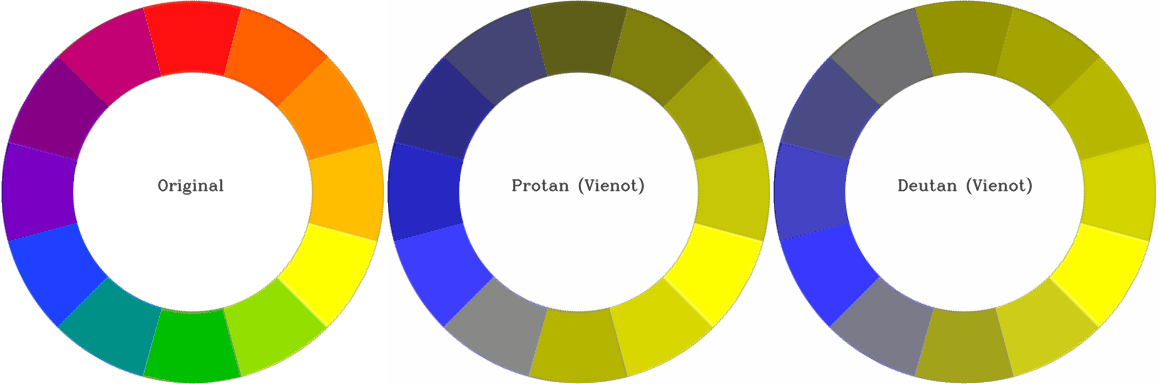

In [18]:
# collapse-hide

def simulate_dichromacy_vienot(im, projection_matrix):
    color_mat = lms_model.linearRGB_from_LMS @ projection_matrix @ lms_model.LMS_from_linearRGB
    im_linear_rgb = convert.linearRGB_from_sRGB(convert.as_float32(im))
    im_protan_linear_rgb = convert.apply_color_matrix(im_linear_rgb, color_mat)
    return convert.as_uint8(convert.sRGB_from_linearRGB(im_protan_linear_rgb))

import urllib.request
import cv2

pngdata = urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/d/d7/Byrcolorwheel.png').read()
# pngdata = urllib.request.urlopen('http://www.vischeck.com/images//poppies.jpg').read()
im = cv2.imdecode(np.frombuffer(pngdata, dtype=np.uint8), cv2.IMREAD_COLOR)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) # OpenCV flips the channels by default.

im_protan = simulate_dichromacy_vienot(im, H_protan)
im_deutan = simulate_dichromacy_vienot(im, H_deutan)
im_original = im.copy()
cv2.putText(im_original, 'Original',        (157,190), cv2.FONT_HERSHEY_COMPLEX, 0.5, (64,64,64), 1, cv2.LINE_AA)
cv2.putText(im_protan,   'Protan (Vienot)', (125,190), cv2.FONT_HERSHEY_COMPLEX, 0.5, (64,64,64), 1, cv2.LINE_AA)
cv2.putText(im_deutan,   'Deutan (Vienot)', (125,190), cv2.FONT_HERSHEY_COMPLEX, 0.5, (64,64,64), 1, cv2.LINE_AA)
px.imshow(np.hstack([im_original, im_protan, im_deutan]), height=400).update_layout(hide_image_axes)

### What about tritanopes?

If we want a one-plane solution for tritanopes we can use the same method but using the black-white-red-cyan plane instead of the black-white-blue-yellow plane we used for protanopes and deuteranopes. As we observed before it's not a very nice fit, but let's try it anyway and we'll compare that with the Brettel 1997 method next.

Normal (tritan) =  [-0.00048455  0.00292798 -0.03960095]

Projection matrix for tritan = 
  array([[ 1.        ,  0.        ,  0.        ],
         [ 0.        ,  1.        ,  0.        ],
         [-0.01223581,  0.07393711,  0.        ]])




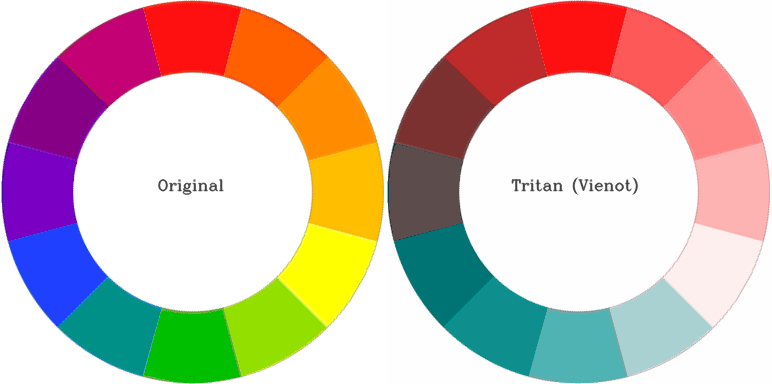

In [19]:
v_red = lms_of_key(KBMRGCWY, 'R') # - K which is ommitted since it's zero
v_cyan = lms_of_key(KBMRGCWY, 'C')  # - K which is ommitted since it's zero
n = np.cross(v_cyan, v_red)
print ('Normal (tritan) = ', n)

H_tritan = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [-n[0]/n[2], -n[1]/n[2], 0],
])

printMatrix('\nProjection matrix for tritan', H_tritan)
print()

im_tritan = simulate_dichromacy_vienot(im, H_tritan)
cv2.putText(im_tritan,   'Tritan (Vienot)', (125,190), cv2.FONT_HERSHEY_COMPLEX, 0.5, (64,64,64), 1, cv2.LINE_AA)
px.imshow(np.hstack([im_original, im_tritan]), height=400).update_layout(hide_image_axes)

# Comparing Viénot 1999 and Brettel 1997

Let's implement {% cite brettel_computerized_1997 %} so we can compare and see whether the extra complexity is worth it. The implementation is very similar to the Viénot approach, but instead of projecting on just one plane we have to project to one of the 2 planes. The plane on which to project depends on the LMS color. The paper directly gives a simple criteria to decide, but it was not so obvious to me so I re-did the math. 

Let's take the example of tritanopia to reason about this:

- If the LMS color is on the "same side" as the 485nm point then we should project on that half-plane, otherwise on the 660nm half-plane.

- The separation is determined by the diagonal $K-E$

- The projection is along the S axis, so we need to determine if the point is on the same side of the plane oriented along the S axis that goes through the K-E diagonal (black-equal energy). A third point on that plane is for example $K+(0,0,1) = (0,0,1)$ since $K$ is the origin.

- Now to determine the side of any point $P = (P_l,P_m,P_s)$ w.r.t to a plane, we can check the sign of the dot-product of a vector going from the plane to the point with the plane normal.

- The plane normal is given by the cross-product of two vectors on the plane: $$n = (E-K) \times ((0,0,1)-K) = E \times (0,0,1) = (E_m,-E_l,0)$$

- So the dot product becomes: $P . n = P_l.E_m - P_m.E_l$. And this is positive if $P_l.E_m > P_m.E_l$. The Brettel paper gives the equivalent condition $\frac{P_l}{P_m} > \frac{E_l}{E_m}$ since all the quantities are positive.

Let's start with the tritanopes for once since those are the most likely to have a significant difference. We first need to compute the 2 projection planes.

In [20]:
v_E = lms_of_key(KBMRGCWY, 'E') # - K which is omitted since it's zero
v_485 = lms_of_key(KBMRGCWY, '485nm') # - K which is omitted since it's zero
v_660 = lms_of_key(KBMRGCWY, '660nm')  # - K which is omitted since it's zero
n1 = np.cross(v_E, v_485) # first plane
n2 = np.cross(v_E, v_660) # second plane

H_tritans_brettel = [
    np.array([
        [1, 0, 0],
        [0, 1, 0],
        [-n1[0]/n1[2], -n1[1]/n1[2], 0]]),
    np.array([
        [1, 0, 0],
        [0, 1, 0],
        [-n2[0]/n2[2], -n2[1]/n2[2], 0]])
]

printMatrix('\nProjection matrix for tritan (485nm)', H_tritans_brettel[0])
printMatrix('\nProjection matrix for tritan (660nm)', H_tritans_brettel[1])


Projection matrix for tritan (485nm) = 
  array([[ 1.        ,  0.        ,  0.        ],
         [ 0.        ,  1.        ,  0.        ],
         [-0.05914768,  0.16570083,  0.        ]])

Projection matrix for tritan (660nm) = 
  array([[ 1.        ,  0.        ,  0.        ],
         [ 0.        ,  1.        ,  0.        ],
         [-0.00202713,  0.05209485,  0.        ]])


Now we can create the simulation function and see the results.


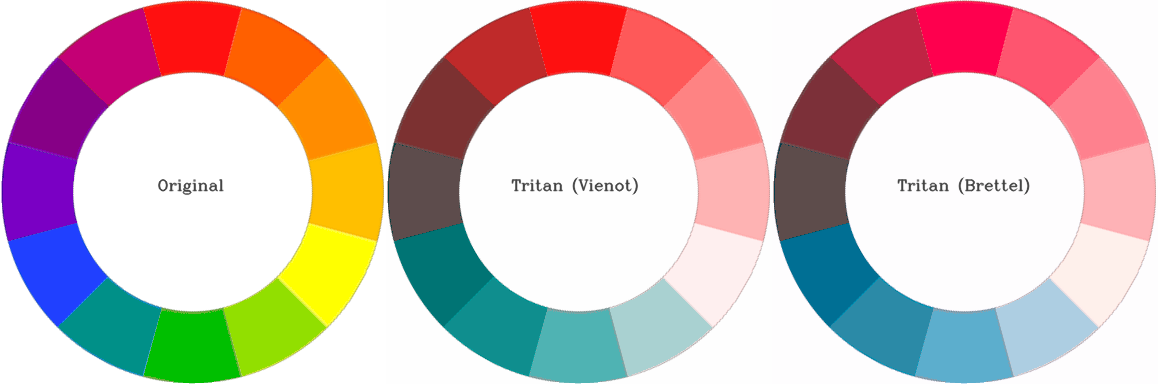

In [21]:
# collapse-hide

def projection_matrix(plane_normal, anomaly: simulate.Deficiency):
    n = plane_normal
    if anomaly == simulate.Deficiency.PROTAN:
        return np.array([
            [0., -n[1]/n[0], -n[2]/n[0]],
            [0, 1, 0],
            [0, 0, 1] 
        ])
    if anomaly == simulate.Deficiency.DEUTAN:
        return np.array([
            [1, 0, 0],
            [-n[0]/n[1], 0, -n[2]/n[1]],
            [0, 0, 1] 
        ])
    if anomaly == simulate.Deficiency.TRITAN:
        return np.array([
            [1, 0, 0],
            [0, 1, 0],
            [-n[0]/n[2], -n[1]/n[2], 0]
        ])
    return None

def simulate_dichromacy_brettel(im, lms_E, lms_on_wing1, lms_on_wing2, anomaly: simulate.Deficiency):
    n1 = np.cross(lms_E, lms_on_wing1) # first plane
    n2 = np.cross(lms_E, lms_on_wing2) # second plane
    n_sep_plane = np.cross(lms_E, simulate.lms_confusion_axis(anomaly)) # separation plane going through the diagonal
    # Swap the input so that wing1 is on the positive side of the separation plane
    if np.dot(n_sep_plane, lms_on_wing1) < 0:
        n1, n2 = n2, n1
        lms_on_wing1, lms_on_wing2 = lms_on_wing2, lms_on_wing1
    
    H1 = projection_matrix(n1, anomaly)
    H2 = projection_matrix(n2, anomaly)
    
    im_linear_rgb = convert.linearRGB_from_sRGB(convert.as_float32(im))
    im_lms = convert.apply_color_matrix(im_linear_rgb, lms_model.LMS_from_linearRGB)
    im_H1 = convert.apply_color_matrix(im_lms, H1)
    im_H2 = convert.apply_color_matrix(im_lms, H2)
    H2_indices = np.dot(im_lms, n_sep_plane) < 0

    # Start with H1, then overwrite the pixels that are closer to plane 2 with im_H2
    im_H = im_H1
    im_H[H2_indices] = im_H2[H2_indices]
    im_linear_rgb = convert.apply_color_matrix(im_H, lms_model.linearRGB_from_LMS)
    return convert.as_uint8(convert.sRGB_from_linearRGB(im_linear_rgb))

im_tritan_brettel = simulate_dichromacy_brettel(im, lms_of_key(KBMRGCWY, 'E'), lms_485, lms_660, simulate.Deficiency.TRITAN)
cv2.putText(im_tritan_brettel, 'Tritan (Brettel)', (125,190), cv2.FONT_HERSHEY_COMPLEX, 0.5, (64,64,64), 1, cv2.LINE_AA)
px.imshow(np.hstack([im_original, im_tritan, im_tritan_brettel])).update_layout(hide_image_axes)

We can do the same for protans and deutans and complete the comparison.


Projection matrix for protan (475nm) = 
  array([[ 0.        ,  2.2611842 , -5.66553395],
         [ 0.        ,  1.        ,  0.        ],
         [ 0.        ,  0.        ,  1.        ]])
Projection matrix for protan (575nm) = 
  array([[ 0.        ,  2.18378218, -4.05510983],
         [ 0.        ,  1.        ,  0.        ],
         [ 0.        ,  0.        ,  1.        ]])

Projection matrix for deutan (475nm) = 
  array([[ 1.        ,  0.        ,  0.        ],
         [ 0.44224615,  0.        ,  2.50556056],
         [ 0.        ,  0.        ,  1.        ]])
Projection matrix for deutan (575nm) = 
  array([[ 1.        ,  0.        ,  0.        ],
         [ 0.45792113,  0.        ,  1.85692047],
         [ 0.        ,  0.        ,  1.        ]])



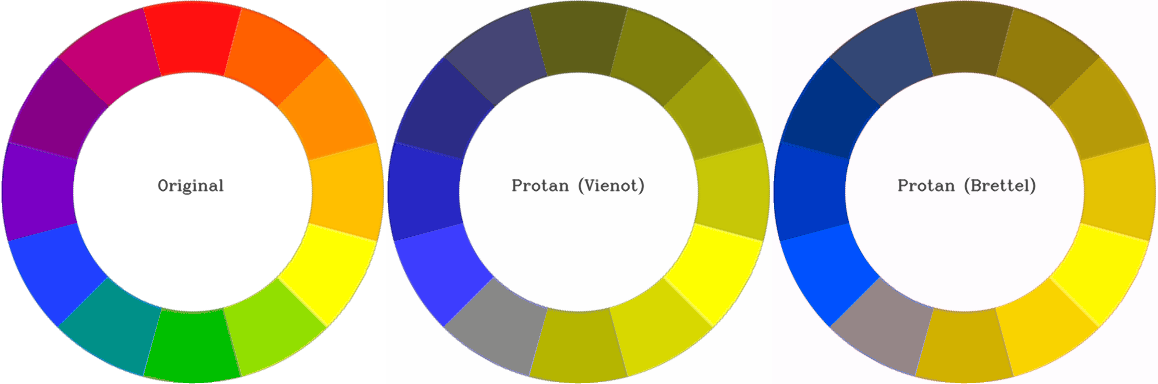

In [22]:
# collapse-hide

v_E = lms_of_key(KBMRGCWY, 'E') # - K which is omitted since it's zero
v_475 = lms_of_key(KBMRGCWY, '475nm') # - K which is omitted since it's zero
v_575 = lms_of_key(KBMRGCWY, '575nm')  # - K which is omitted since it's zero
n1 = np.cross(v_E, v_475) # first plane
n2 = np.cross(v_E, v_575) # second plane

H_protans_brettel = [
    np.array([
        [0., -n1[1]/n1[0], -n1[2]/n1[0]],
        [0, 1, 0],
        [0, 0, 1]]),
    np.array([
        [0., -n2[1]/n2[0], -n2[2]/n2[0]],
        [0, 1, 0],
        [0, 0, 1]])]

H_deutans_brettel = [
    np.array([
        [1, 0, 0],
        [-n1[0]/n1[1], 0, -n1[2]/n1[1]],
        [0, 0, 1]]),
    np.array([
        [1, 0, 0],
        [-n2[0]/n2[1], 0, -n2[2]/n2[1]],
        [0, 0, 1]])
]

printMatrix('\nProjection matrix for protan (475nm)', H_protans_brettel[0])
printMatrix('Projection matrix for protan (575nm)', H_protans_brettel[1])

printMatrix('\nProjection matrix for deutan (475nm)', H_deutans_brettel[0])
printMatrix('Projection matrix for deutan (575nm)', H_deutans_brettel[1])

im_protan_brettel = simulate_dichromacy_brettel(im, lms_E, lms_475, lms_575, simulate.Deficiency.PROTAN)
cv2.putText(im_protan_brettel, 'Protan (Brettel)', (125,190), cv2.FONT_HERSHEY_COMPLEX, 0.5, (64,64,64), 1, cv2.LINE_AA)
px.imshow(np.hstack([im_original, im_protan, im_protan_brettel]), height=400).update_layout(hide_image_axes)


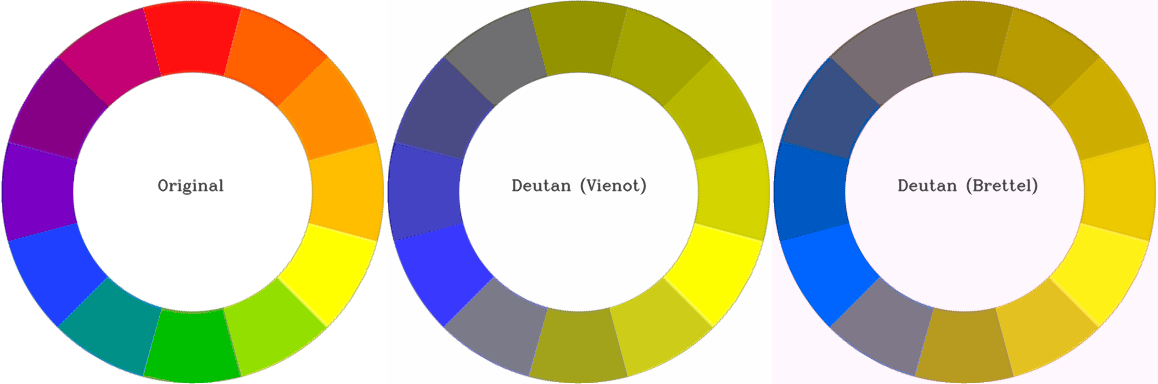

In [23]:
# collapse-hide

im_deutan_brettel = simulate_dichromacy_brettel(im, lms_E, lms_475, lms_575, simulate.Deficiency.DEUTAN)
cv2.putText(im_deutan_brettel, 'Deutan (Brettel)', (125,190), cv2.FONT_HERSHEY_COMPLEX, 0.5, (64,64,64), 1, cv2.LINE_AA)
px.imshow(np.hstack([im_original, im_deutan, im_deutan_brettel]), height=400).update_layout(hide_image_axes)

For protanopia and deuteranopia the results are significantly more similar, so the more efficient Viénot approach is a good choice. It also better preserves with extreme values like pure RGB white (255,255,255) since the plane diagonal goes exactly through white and not E in the LMS space.

# What about anomalous trichromacy?

Most people with CVD still have _some_ perception with the deficient kind of cones. The Brettel 1997 and the Viénot 1999 models can be adjusted to be more progressive by not projecting all the way towards the plane.

{% cite flatla_so_2012 %} (refined for a mobile app in {% cite macalpine_real_time_2016 %}) propose to make a fixed step towards the plane, with the step size determined from a custom calibration. The step is actually made in the L*u*v color space since a fixed step there is supposed to be perceptually uniform in that space.

Another approach was proposed was {% cite machado_physiologically_based_2009 %}, where the degree of severity comes from an amount of shift in the peak wavelength of the cone response. Dichromacy can be represented when e.g. the M-cone is shifted to align with the S-cone, effectively suppressing it. By shifting it less, various degrees of severity can be simulated. At the end of the day {% cite macalpine_real_time_2016 } mentions that their results are quite similar, the main difference being that with {% cite machado_physiologically_based_2009 %} the step size is proportional to the distance between the point and the plane, while the steps are fixed in {% cite macalpine_real_time_2016 %}. It's unclear which one is more accurate from a perception point of view.

It's also trivially possible to extend the Viénot 1999 or Brettel 1997 methods by introducing a severity factor between 0 and 1 that does a linear interpolation between the dichromat simulation and the original image (in the linear RGB space). In practice this gives pretty good results, making Brettel 1997 and Machado 2009 quite close for protanomaly and deuteranomaly. Here is an example for protanomaly (generated with the implementations of [DaltonLens-Python](https://github.com/DaltonLens/DaltonLens-Python)):

<!-- Image tags have to be unindented for nbdev to catch them :-( -->
<table>
    <tr><th>Original</th><th>Machado 2009 (1.0 severity)</th><th>Brettel 1997 (1.0 severity)</th></tr>
    <tr><td>
<img src="simulation_images/rgbspan.png"></td><td>
<img src="simulation_images/rgbspan_protan_machado2009.png"></td><td>
<img src="simulation_images/rgbspan_protan_brettel1997.png"></td></tr>
     <tr><th>Original</th><th>Machado 2009 (0.5 severity)</th><th>Brettel 1997 (0.5 severity)</th></tr>
    <tr><td>
<img src="simulation_images/rgbspan.png"></td><td>
<img src="simulation_images/rgbspan_protan_machado2009_0.5.png"></td><td>
<img src="simulation_images/rgbspan_protan_brettel1997_0.5.png"></td></tr>
</table>

The main problem then becomes to estimate the severity factor for each individual. {% cite flatla_so_2012 %} uses a calibration method where a number of colored patterns are shown to the user with an increasing distance from the neutral gray until she can distinguish them. And that distance is then used to determine the severity factor. But we're still lacking convenient open source tools to do that, so in practice people just have to try various parameters until they can't see the difference between the original and the simulated images.

# Conclusion

We've seen how the most popular CVD simulation methods work and visualized the corresponding projection planes in the LMS space. As we discussed in our [Review of Open Source Color Blindness Simulations](/opensource-cvd-simulation/#How-accurate-are-these-simulations?) we can't expect a perfect accuracy for the simulation. The main source of inaccuracy is the per-person variations as the severity and cone cells sensitivity can vary. So ideally we'd need an individual calibration procedure and a way to inject that calibration in the model. As an intermediate step we'll show in a followup post how we can generate Ishihara-like plates for each model and degree of severity. This will let everyone self-evaluate how good the models are and what severity they have for each model.

The next step after simulation is to try to transform images to help people with CVD to process them. The most well-known approach is the daltonize algorithm from {% cite fidaner_analysis_2005 %}, but it's main advantage is the simplicity and code availability as it is quite rough (it was actually just a small school project!). There are a lot of more recent work in that area, but that'll also be the subject of a future post.

# Bibliography


{% bibliography --cited %}

# Appendix

## Code to generate the confusion lines of the introduction

In [24]:
# collapse-hide

# Debug figure to visualize the confusion lines
fig = px.scatter_3d(KBMRGCWY.loc['K':'Y'], x='L', y='M', z='S', 
                    color='colorhex', color_discrete_map='identity', text='short_name',
                    width=800, height=800)

# Add the parallelepiped lines
df = KBMRGCWY.loc[['K','B','M','R', 'K', 'G', 'Y', 'W', 'C', 'G', 'Y', 'R', 'M', 'W', 'C', 'B']]
fig.add_scatter3d(x=df['L'], y=df['M'], z=df['S'], mode='lines', showlegend=False)

# Add the black-white diagonal
df = KBMRGCWY.loc[['K','W']]
fig.add_scatter3d(x=df['L'], y=df['M'], z=df['S'], mode='lines', showlegend=False, line=dict(width=8, dash='dash', color='gray'))

# add_black_white_yellow_blue_plane(fig, KBMRGCWY)
   
def generate_confusion_line(lms_color, anomaly, num_steps, fig):
    # This returns a line segment along the anomaly projection axis (L, M or S)
    # that passes through the input LMS color and stops at the boundaries of the
    # gamut (the parallelepiped). Then we can walk along that segment with small
    # steps to generate confusion colors.
    segment = geometry.lms_confusion_segment(lms_color, lms_model, anomaly)
    colors = []
    # Ensure num_steps at the end
    step = (1.0 / (num_steps-1)) - 1e-5
    for s in np.arange(0.0, 1.0, step):
        p = segment[0]*(1.0-s) + segment[1]*s
        colors.append (p)
        if fig:
            fig.add_scatter3d(x=[p[0]], y=[p[1]], z=[p[2]], showlegend=False,
                              marker=dict(color=lms_model.sRGB_hexstring_from_LMS(p), 
                                          line=dict(color='Black', width=1)))
    return colors
    
anomaly = simulate.Deficiency.PROTAN
num_steps = 7

# Generate segments that passes through a set of LMS points. To get a nice
# distribution of the segment we sample them from the diagonal Black-Yellow-Blue plane
U = lms_of_key(KBMRGCWY, 'Y') - lms_of_key(KBMRGCWY, 'K')
V = lms_of_key(KBMRGCWY, 'B') - lms_of_key(KBMRGCWY, 'K')
confusion_lines = []
# for uv_plane in itertools.product([0.1,0.25,0.5,0.75,0.9], [0.02,0.1,0.25,0.5,0.75,0.9]):
for uv_plane in [(0.2,0.2), (0.5,0.5), (0.25, 0.75), (0.75, 0.25), (0.8, 0.8)]:
    lms_color = uv_plane @ np.array([U,V])
    colors = generate_confusion_line(lms_color, anomaly, num_steps, fig)
    confusion_lines.append(colors)

print (f"# Confusion lines for {anomaly}")
print ("confusion_lines = [")
for line in confusion_lines:
    print (" "*4 + "pd.DataFrame.from_records([")
    lines_as_text = []
    for c in line:
        srgb_hex = lms_model.sRGB_hexstring_from_LMS(c)
        L, M, S = c[0], c[1], c[2]
        linear_rgb = convert.apply_color_matrix(c, lms_model.linearRGB_from_LMS)
        linear_rgb = np.clip(linear_rgb,0.,1.0)
        R, G, B = linear_rgb[0], linear_rgb[1], linear_rgb[2]
        lines_as_text.append(" "*8 + f"({L:.4f}, {M:.4f}, {S:.4f}, {R:.4f}, {G:.4f}, {B:.4f}, '{srgb_hex}')")
    print (",\n".join(lines_as_text) + "],")    
    print (" "*8 + "columns = ['L', 'M', 'S', 'R', 'G', 'B', 'sRGB_hex']),")
print("]")
# Uncomment to show the confusion lines.
# fig.show()

confusion_matrices = []
for confusion_line in confusion_lines:
    confusion_matrix = np.expand_dims(np.array(confusion_line), axis=0)
    confusion_matrix = convert.apply_color_matrix(confusion_matrix, lms_model.linearRGB_from_LMS)
    confusion_matrix = convert.sRGB_from_linearRGB(confusion_matrix)
    confusion_matrices.append(np.clip(confusion_matrix*255.0, 0., 255.).astype(np.uint8))
fig = px.imshow(np.vstack(confusion_matrices), title=f"Confusion lines for {anomaly}. The colors on each row should appear similar to a dichromat.").update_layout(hide_image_axes).update_layout(margin=None)
fig.show()

# Confusion lines for Deficiency.PROTAN
confusion_lines = [
    pd.DataFrame.from_records([
        (0.2309, 0.0690, 0.0035, 1.0000, 0.1022, 0.1960, '#fe5a7a'),
        (0.2101, 0.0690, 0.0035, 0.8333, 0.1226, 0.1968, '#eb627a'),
        (0.1893, 0.0690, 0.0035, 0.6667, 0.1430, 0.1977, '#d5697a'),
        (0.1684, 0.0690, 0.0035, 0.5000, 0.1633, 0.1985, '#bb707b'),
        (0.1476, 0.0690, 0.0035, 0.3334, 0.1837, 0.1993, '#9c767b'),
        (0.1268, 0.0690, 0.0035, 0.1667, 0.2041, 0.2002, '#717c7b'),
        (0.1060, 0.0690, 0.0035, 0.0001, 0.2244, 0.2010, '#00827b')],
        columns = ['L', 'M', 'S', 'R', 'G', 'B', 'sRGB_hex']),
    pd.DataFrame.from_records([
        (0.3899, 0.1726, 0.0088, 1.0000, 0.4389, 0.4975, '#feb0bb'),
        (0.3690, 0.1726, 0.0088, 0.8333, 0.4593, 0.4983, '#ebb4bb'),
        (0.3482, 0.1726, 0.0088, 0.6667, 0.4796, 0.4992, '#d5b8bb'),
        (0.3274, 0.1726, 0.0088, 0.5000, 0.5000, 0.5000, '#bbbbbb'),
        (0.3066, 0.1726, 0.0088, 0.3334, 0.5204, 0.50

In [25]:
#hide
# The cell above will show a nice bibliography in the HTML output.